In [44]:
#@title IMPORTS
import random
import numpy as np
import matplotlib.pyplot as plt
!pip install Bio
from Bio import SeqIO
from Bio.Seq import Seq
from collections import Counter 
from Bio.Cluster import kcluster
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import difflib
import seaborn as sns; sns.set_theme()
from collections import defaultdict
import collections

#!pip install ipython-autotime

In [195]:
###CREATE DEMO DATA TO TEST CODE
#4 Constructs
#10 Amino Acids Each

#STEM1234568910METS

stem = 'AAAA'
randomized_len = 10
triplet_start = 1
number_of_seqs = 100000
selection_advantage_single_nt = 0.2
background_selection = 0.01
preference = 'AUG'

#Create Pool
random_pool = []
for j in range(number_of_seqs):
    randomized_seq = stem
    for i in range(randomized_len):
        new_nt = random.choice(['C', 'G', 'A', 'U'])
        randomized_seq+=new_nt
    randomized_seq+='UUUU'
    random_pool.append(randomized_seq)

#Add preference via 1 round of selection
#Add stochasticity 
selected_pool = []

for seq in random_pool:
    selection_probability = background_selection
    for position in range(3):
        if seq[len(stem)+triplet_start-1+position] == preference[position]:
            selection_probability+=selection_advantage_single_nt

    if selection_probability>random.random():
        selected_pool.append(seq)

print('Starting Pool Length: '+str(number_of_seqs))
print('Selected Pool Length: '+str(len(selected_pool)))
print('Selected Pool Unique Sequences: '+str(len(list(set(selected_pool)))))

Starting Pool Length: 100000
Selected Pool Length: 16147
Selected Pool Unique Sequences: 15907


In [196]:
#Instructions:
#1) Name the raw .fastq file: 'Aleks.fastq', UNZIPPED
#2) Input the following parameters - defaults are already set
#3) On the bar at the top, press 'Runtime' and then 'Restart and Run All'

#Take the reverse complement? Enter 'yes' or 'no'
rc = 'no'

#Desired Region to analyze (e.g. if 8nt constant region in 56nt sequence, input 'start, stop = 8, 48')
start, stop = 13, 23

#Quality Cutoff - what fraction of positions should have <1% error probability?
quality_cutoff = 0.9

#Number of Clusters (I WOULD MAKE THIS >50)
k = 50

In [197]:
#@title STATISTICS (note: this takes a few mins per round)

round = open('/Users/zoeweiss/Desktop/Desktop/fastq/smaller_ai/Aleks4.fastq').readlines()
quality = round[3::4]
seqs = round[1::4]
print('Number of raw seqs: '+str(len(seqs))) 

#Remove duplicates:
unique_seqs = []
unique_qualities = []
indicies_of_unique_seqs = list(np.unique(seqs, return_index=True)[1])
for index in sorted(np.unique(seqs, return_index = True)[1])[:-1]:
  unique_qualities.append(quality[index])
  unique_seqs.append(seqs[index])
print('Number of unique seqs: '+str(len(unique_seqs))) 

#Counts of all seqs
seq_dict = Counter(seqs)
seq_dict_list = [(k, v) for k, v in seq_dict.items()]
sorted_seq_dict = sorted(seq_dict_list, key = lambda x: x[1], reverse=True)
sorted_seq_dict_inve = sorted(seq_dict_list, key = lambda x: x[1])

#Take RC if desired
pre_trim = []
if rc == 'yes':
  rc_seqs = []
  for sequence in unique_seqs:
      rc_seqs.append(str(Seq(sequence).reverse_complement()).strip('\n'))
  pre_trim = rc_seqs
else:
  for sequence in unique_seqs:
      pre_trim.append(str(Seq(sequence)).strip('\n'))
if rc == 'yes':
  print('Number of seqs after rc: '+str(len(pre_trim))) 

#Trim
trimmed = []
for seq in pre_trim:
  trimmed.append(seq[(start-1):(stop-1)])
print('Number of seqs after trimming: '+str(len(trimmed))) 

#Filter by quality
high_quality = []
acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
for seq in range(len(unique_qualities)):
  overlap=0
  for char in list(set(unique_qualities[seq]).intersection(acceptable_quals_1_percent_error)):
        overlap+=unique_qualities[seq].count(char)
  if overlap/len(unique_qualities[1])>quality_cutoff:
        high_quality.append(trimmed[seq].strip("\n"))
print('Number of high quality seqs: '+str(len(high_quality))) 

Number of raw seqs: 2519
Number of unique seqs: 1615
Number of seqs after trimming: 1615
Number of high quality seqs: 592


In [198]:
#@title MOST ABUNDANT SEQUENCES [NOT FILTERED BY QUALITY]
#10 Top Sequences in the last round
print('10 Most Abundant Sequences, Counts')
for seq in sorted_seq_dict[:10]:
  print(seq[0].strip("\n"), seq[1])

10 Most Abundant Sequences, Counts
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 252
ACTCACTGACACAGATCCACTCACGGACAGCGCCTAGCTAGCGCTGACTAGGACAGATGAGCGGCGGAACCACGCTGTCCT 98
ACTCACTGACACAGATCCACTCACGGACAGCGGAACCCTTATCACAGTCGTGCGGATTTGTAAGCCTAAGCGCGCTGTCCT 44
ACTCACTGACACAGATCCACTCACGGACAGCGTTAGTGAAATTGGTGCCCAAGCAGAGAATTGGGATAAATCCGCTGTCCT 43
ACTCACTGACACAGATCCACTCACGGAGCGTATTGGGTGCCGATTTCCTCTAATTTTAAAGTGCGGATAACGCTGTCCTTT 36
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTACCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGTCCT 21
ACTCACTGACACAGATCCACTCACGGACAGCGAGAGACCGTGAGCTTGCGGAATGTTAGCAGAACAGAACTGCGCTGTCCT 19
ACTCACTGACACAGATCCACTCACGGACGCGCCAGAAGATCAATTTAGTGCGATTGCTAAAGACGTAAACCCGCTGTCCTT 18
ACTCACTGACACAGATCCACTCACGGACAGCGGAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCTCGCTGCCCT 18
ACTCACTGACACAGATCCACTCACGGACAGCGAGCCACTGCGGAAGACCTTAAGAGGTGTAATTGCTCACCCCGCTGTCCT 18


In [199]:
#@title FUNCTION TO FIND CONSERVED POSITIONS
#Idtenify conserved positions in cluster 1

def make_heatmap(seqs_to_analyze):
  heatmap_data = []

  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'U' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)


  fig, ax = plt.subplots(figsize = (30,6));
  im = ax.imshow(np.array(heatmap_data).transpose(), interpolation='nearest', cmap='YlOrRd');
  im.set_clim(0,1)
  cbar = fig.colorbar(im, orientation='vertical',)
  y_label_list = ['', 'A', 'C', 'G', 'T', ''];
  ax.set_yticks(range(-1, 1+len(heatmap_data[0])));
  ax.set_yticklabels(y_label_list);
  ax.set_xticks(range(len(heatmap_data)));
  ax.set_xticklabels(range(1, len(heatmap_data)+1));
  ax.grid(False)
  plt.show()
  return heatmap_data

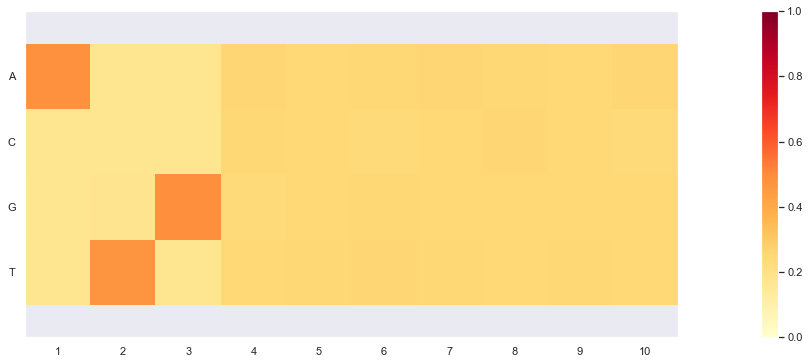

[[0.48442435127268224,
  0.16981482628352015,
  0.1740880658945934,
  0.1716727565492042],
 [0.17359261782374436,
  0.17210627361119712,
  0.17786585743481761,
  0.47643525113024093],
 [0.1696909642658079,
  0.1709915154517867,
  0.49043165913172726,
  0.16888586115067813],
 [0.2553415495138416,
  0.2516256889824735,
  0.2452467950702917,
  0.2477859664333932],
 [0.24790982845110546,
  0.24908651761937203,
  0.24921037963708428,
  0.2537932742924382],
 [0.25168761999132966,
  0.2406019694060816,
  0.25094444788505604,
  0.25676596271753266],
 [0.25558927354926614,
  0.24679507029169506,
  0.24698086331826347,
  0.2506347928407754],
 [0.251377964947049,
  0.2539171363101505,
  0.24716665634483187,
  0.24753824239796865],
 [0.24970582770793337,
  0.24964389669907722,
  0.24809562147767386,
  0.2525546541153155],
 [0.2572614107883817,
  0.24605189818542145,
  0.24871493156623523,
  0.2479717594599616]]

In [200]:
###TEMPORARY
high_quality = selected_pool
high_quality_trimmed = []
for seq in list(high_quality):
    high_quality_trimmed.append(seq[len(stem):(-len(stem))])

make_heatmap(high_quality_trimmed)